# Аналитика рынка заведений общественного питания Москвы

В данном проекте нам предстоит использовать много интересных инструментов. Помимо привычных `pandas`, `numpy` и `matplotlib`, мы активно поработаем с `seaborn`, а также применим библиотеки для парсинга (`requests`, `re`, `BeautifulSoup`, `IO`). В конце проекта - простая презентация результатов в `pdf`.
Пару слов о легенде. Прежде чем начинать своё дело, даже самое инновационное, необходимо тщательно проанализировать рынок. Мы изучим открытые данные о столичных ресторанах и кафе и дадим практические рекомендации нашим партнерам, решившим открыть совершенно новое заведение с роботами-официантами. Нам предстоит:
1. [Импорт и предобработка данных](#import)
2. [Анализ данных](#analysis)
3. [Выводы](#concl)
4. [Презентация данных инвесторам](#present)

В нашей работе мы сделаем упор на графическое представление данных: так нас лучше смогут понять люди, далёкие от аналитики. За работу!

## <a id="import">Импорт и предобработка данных</a> 

Установим все необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 300)

Импортируем данные и бросим беглый взгляд на их структуру:

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
display(data.head(10))
print('Дубликаты: ',data.duplicated().sum())
print('Длина датасета: ', len(data))
print('***')
display(data.info())
display(data.describe())

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корпус 1",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строение 1",120


Дубликаты:  0
Длина датасета:  15366
***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


В датафрейме содержится информация о 15366 точках общественного питания, пропущенных и явно дублирующихся нет. На первый взгляд, всё нормально и с типами данных (кроме того, что булев тип заменен на object в столбце "сетевой", но это не так принципиально). Поищем теперь неявные дубликаты - в данных много object'ов, которые могут вносить смуту разными регистрами.

In [4]:
for column in data.columns:
    if data[column].dtype == 'O':
        x = data[column].nunique()
        y = data[column].str.lower().nunique()
        if x != y:
            print(f'В столбце {column} есть неявные дубликаты, их количество:', x-y)
        else:
            print(f'В столбце {column} нет неявных дубликатов')

В столбце object_name есть неявные дубликаты, их количество: 469
В столбце chain нет неявных дубликатов
В столбце object_type нет неявных дубликатов
В столбце address нет неявных дубликатов


Довольно наглядно: где-то в данных притаились дубликаты из-за разных регистров. Кроме того, заметно, что в названиях заведений есть кавычки и слова навроде "кафе", "столовая", станции метро, районы города... Постараемся оставить только название: создадим список со стоп-словами, поищем их в названиях кафе и заменим на пропуски. Пока нам не нужно знать конкурентов в лицо, скорее - видеть общие тенденции, поэтому с названиями компаний можно обращаться "небрежно" - если нам понадобится конкретное учреждение, мы найдем его в изначальных данных. Для этого создадим второй столбец с именами.

In [5]:
req = requests.get('https://realty.ru/metro?yclid=2389758196098557674') #парсим названия станций метро
soup = BeautifulSoup(req.text, 'lxml')
metro = []
for tag_content in soup.find_all('a'):
    metro.append(tag_content.text.lower())

In [6]:
req = requests.get('https://realty.ru/cities/4486') #парсим районы Москвы
soup = BeautifulSoup(req.text, 'lxml')
districts = []
for tag_content in soup.find_all('a'):
    districts.append(tag_content.text.lower())

In [7]:
stop_words = metro + districts + list(['«','»','лаундж-бар', 'пбо','кофейня']) + list(data['object_type'].unique())

In [8]:
data['object_name_2'] = data['object_name'].str.lower()
for i in stop_words:
    data['object_name_2'] = data['object_name_2'].apply(lambda x: x.replace(f"{i}",""))
data['object_name_2'] = data['object_name_2'].apply(lambda x: x.replace(" ",""))
data['object_name_2'] = data['object_name_2'].apply(lambda x: x.replace("-",""))

In [9]:
print('Количество обработанных дубликатов:', \
      (data[data['chain']=='да']['object_name'].nunique() - \
      data[data['chain']=='да']['object_name_2'].nunique())
)

Количество обработанных дубликатов: 305


На этапе предобработки мы избавились от неявных дубликатов: привели строки к нижнему регистру, убрали из названий заведений станции метро и районы Москвы, а также слова, характеризующие вид заведения, чтобы легче обсчитывать сетевые в последующих шагах.

## <a id="analysis">Анализ данных</a> 

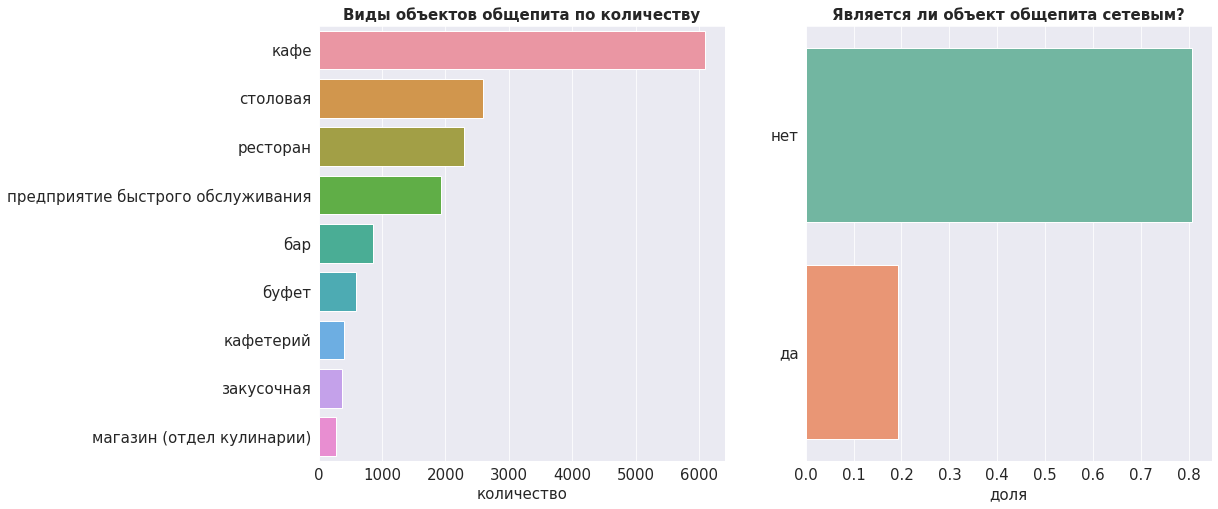

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
sns.barplot(x = 'object_type', y='index', data = data['object_type'].value_counts().reset_index())
plt.title('Виды объектов общепита по количеству', fontsize=15, fontweight="bold")
plt.ylabel('')
plt.xlabel('количество', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(1,2,2)
sns.barplot(x = data['chain'].value_counts(normalize=True), y = data['chain'].value_counts().index)
plt.title('Является ли объект общепита сетевым?', fontsize=15, fontweight="bold")
plt.ylabel('')
plt.xlabel('доля',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Абсолютное большинство заведений представлено кафе (более 6 тысяч), за ними идут столовые (около 2,5 тыс) и рестораны (около 2,3 тыс). Кафе как правило небольшое, не требует много сотрудников и, следовательно, открыть его легче; относительно ресторанов там быстрее обслуживают и ниже цены, а относительно столовых разнообразнее меню. Более 80% заведений - несетевые. 

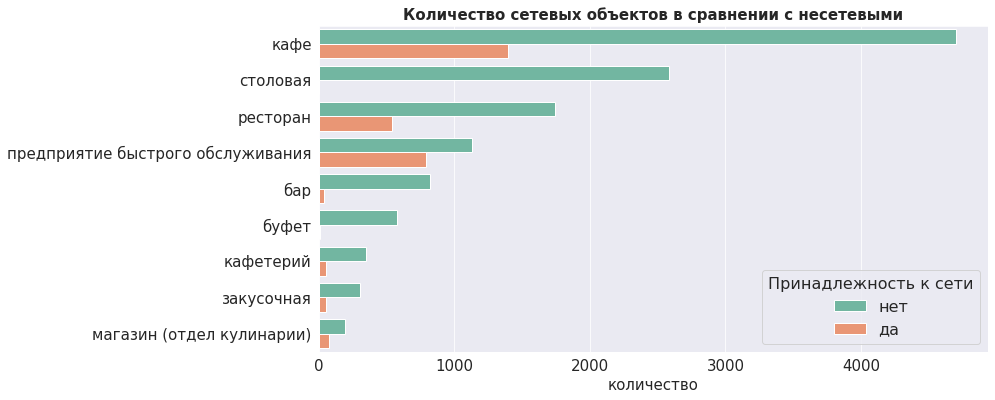

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(y='object_type', data=data, hue='chain', order=data['object_type'].value_counts().index)
plt.title('Количество сетевых объектов в сравнении с несетевыми', fontsize=15, fontweight="bold")
plt.ylabel('')
plt.xlabel('количество', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title='Принадлежность к сети', title_fontsize=16, fontsize=16)
plt.show()

Самыми "сетевыми" видами заведений являются предприятия быстрого обслуживания, за ними (но уже с меньшей долей сетевых относительно несетевых) идут кафе и рестораны. Сетевых баров, буфетов и столовых практически нет: бары это чаще всего "авторская" тема, их создатели делают ставку на уникальный экспириенс, а столовые и буфеты часто организуются при школах, вузах и предприятиях.

In [12]:
chains = (
    data[data['chain']=='да']
    .groupby('object_name_2', as_index=False)
    .agg({'id':'count', 'number':'sum'})
    .sort_values(by='id', ascending=False)
    .rename(columns={'id':'count', 'number':'sum_places'})
)
chains = chains[chains['count'] > 1]
chains['mean_places'] = chains['sum_places'] / chains['count']

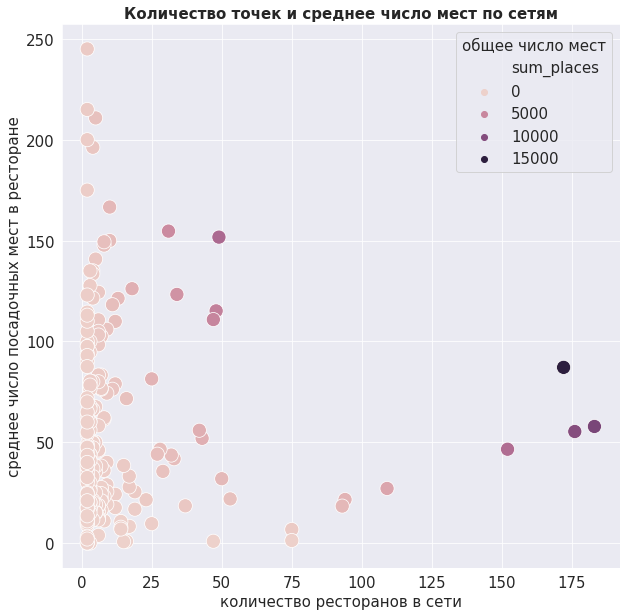

In [13]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=chains, x='count', y='mean_places', hue='sum_places', s=200)
plt.title('Количество точек и среднее число мест по сетям', fontsize=15, fontweight="bold")
plt.xlabel('количество ресторанов в сети',fontsize=15)
plt.ylabel('среднее число посадочных мест в ресторане',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title='общее число мест', title_fontsize=15, fontsize=15)
plt.show()

Самые крупные сети используют стратегию большого числа средних и небольших ресторанов, однако большинство сетей открывают мало ресторанов с различным числом мест. Компании в нашем датасете разные, и прямо утверждать, что "малые и крупные" побеждают, мы не можем. Не каждая сеть хочет и может достичь масштабов KFC и Шоколадницы. Однако, если хочет, то ее путь - много маленьких заведений.

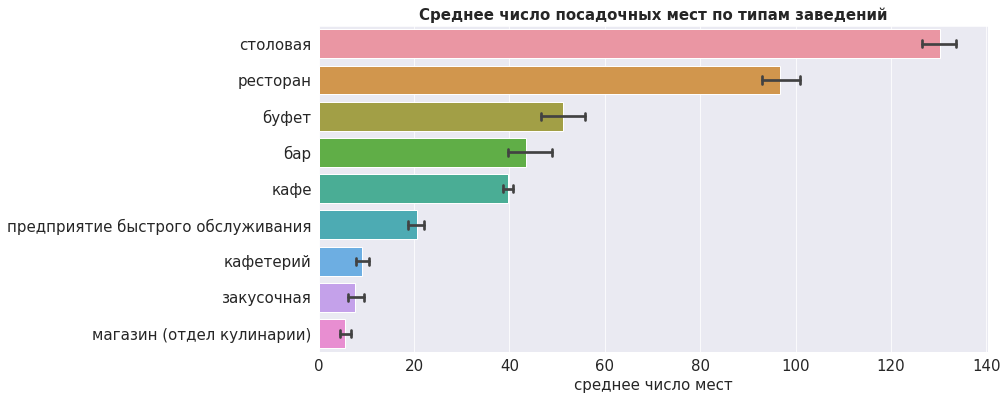

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(y='object_type', x='number', data=data, capsize=0.2,
            order=data.groupby('object_type').agg({'number':'mean'}).sort_values(by='number', ascending=False).index)
plt.title('Среднее число посадочных мест по типам заведений', fontsize=15, fontweight="bold")
plt.ylabel('')
plt.xlabel('среднее число мест', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

В среднем посадочных мест больше всего в столовых (около 130, они создаются с расчетом на пиковую нагрузку в обед), за ними идут рестораны (в них часто проводят мероприятия), после них с большим разрывом буфеты и бары. В кулинарных отделах, что закономерно, посадочных мест меньше всего.

Выделим из адреса улицы и проверим качество работы:

In [15]:
streets = [
    'город','микрорайон',"поселение","деревня","квартал","линия",'улица',"бульвар",
    "проспект","переулок","проезд","площадь","набережная",'тупик','шоссе','аллея'
]
data['streetname'] = 0
for a in range(len(data)):
    x = data['address'][a].split(',')
    for s in streets:
        for i in x:
            if s in i.lower():
                data['streetname'][a] = i

In [16]:
print('Количество оставшихся незаполненными улиц:',len(data[data['streetname'] == 0]))
display(data.head())

Количество оставшихся незаполненными улиц: 0


,id,object_name,chain,object_type,address,number,object_name_2,streetname
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,академия,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,вишневаяметель,Абрамцевская улица


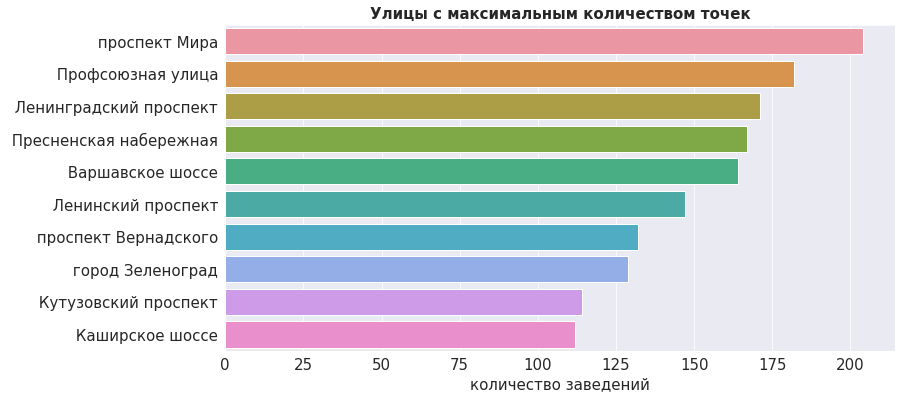

In [17]:
top_street = (
    data.groupby('streetname', as_index=False)
    .agg({'id':'nunique','number':'sum'}).rename(columns={'id':'num_of_points', 'number':'sum_of_places'})
    .sort_values(by='num_of_points', ascending=False)
)
plt.figure(figsize=(12, 6))
sns.barplot(y='streetname', x='num_of_points', data=top_street.head(10))
plt.title('Улицы с максимальным количеством точек', fontsize=15, fontweight="bold")
plt.ylabel('')
plt.xlabel('количество заведений', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

В большинстве случаев улицы нашего списка длинные и направлены к центру города, а на Пресненской наб. стоит деловой центр. Город Зеленоград оказался в списке потому, что для многих адресов в этом городе это единственное, что мы смогли получить. Зато сразу понятно, к какому району-пригороду он принадлежит. Возьмем теперь данные об улицах и районах столицы:

In [18]:
#https://docs.google.com/spreadsheets/d/1MTIfxz38xmA_fZZK5cQo5pxSKmda3Zv6I4RE6403BZk/edit?usp=sharing -
#адрес нужной таблицы на диске
spreadsheet_id = '1MTIfxz38xmA_fZZK5cQo5pxSKmda3Zv6I4RE6403BZk'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
street_df = pd.read_csv(BytesIO(r.content))
street_df.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Сразу обозначилась проблема: где-то "улица" в начале названия, где-то - в конце. Чтобы хорошо "сджойнить" таблицы, придется выделить имя улицы.

In [19]:
dfs = [top_street, street_df]
for df in dfs:
    df['streetname_clean'] = df['streetname'].str.lower()
    for i in streets:
        df['streetname_clean'] = df['streetname_clean'].apply(lambda x: x.replace(f"{i}",""))
    df['streetname_clean'] = df['streetname_clean'].apply(lambda x: x.replace(" ",""))
street_df_new = street_df[['streetname_clean', 'area', 'okrug']].drop_duplicates() #нам не нужен весь датафрейм, как и дубликаты в нем.
top_street_district = top_street.merge(street_df_new, on='streetname_clean', how='outer')
def str_cat(x): #функция, которая поможет нам соединить районы для длинных улиц. Боже, храни stackowerflow!
    return x.str.cat(sep=', ') 
top_street_corr = (
    top_street_district.groupby('streetname', as_index=False)
    .agg({'area':str_cat, 'num_of_points':'mean', 'sum_of_places':'mean'})
    .sort_values(by='num_of_points', ascending=False)
)
top_street_corr['num_of_points'] = top_street_corr['num_of_points'].astype('int')
top_street_corr['sum_of_places'] = top_street_corr['sum_of_places'].astype('int')
for i in range(len(top_street_corr)):
    if len(top_street_corr['area'][i]) < 5:
        top_street_corr['area'][i] = top_street_corr['streetname'][i]
display(top_street_corr.head(10))

,streetname,area,num_of_points,sum_of_places
1465,проспект Мира,"Район Внуково, Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район",204,12790
1013,Профсоюзная улица,"Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан",182,8447
687,Ленинградский проспект,"Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол",171,9010
997,Пресненская набережная,Пресненский район,167,7656
401,Варшавское шоссе,"Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово",164,8606
690,Ленинский проспект,"Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка",147,9330
1461,проспект Вернадского,"Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район",132,8840
1371,город Зеленоград,"Район Крюково, Район Матушкино-Савелки, Панфиловский район",129,10721
677,Кутузовский проспект,"Район Дорогомилово, Район Фили-Давыдково",114,9697
600,Каширское шоссе,"Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное",112,6171


In [20]:
display(top_street_corr.head(10))
good_districts = str_cat(top_street_corr.head(10)['area'])
good_districts = pd.Series(re.split(', ', good_districts)).drop_duplicates()
print('Топ-10 улиц по количеству заведений находятся в следующих районах Москвы:', list(good_districts))

,streetname,area,num_of_points,sum_of_places
1465,проспект Мира,"Район Внуково, Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район",204,12790
1013,Профсоюзная улица,"Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан",182,8447
687,Ленинградский проспект,"Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол",171,9010
997,Пресненская набережная,Пресненский район,167,7656
401,Варшавское шоссе,"Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово",164,8606
690,Ленинский проспект,"Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка",147,9330
1461,проспект Вернадского,"Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район",132,8840
1371,город Зеленоград,"Район Крюково, Район Матушкино-Савелки, Панфиловский район",129,10721
677,Кутузовский проспект,"Район Дорогомилово, Район Фили-Давыдково",114,9697
600,Каширское шоссе,"Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное",112,6171


Топ-10 улиц по количеству заведений находятся в следующих районах Москвы: ['Район Внуково', 'Алексеевский район', 'Ярославский Район', 'Район Марьина роща', 'Останкинский район', 'Район Ростокино', 'Район Свиблово', 'Мещанский район', 'Академический район', 'Район Черемушки', 'Район Ясенево', 'Район Коньково', 'Обручевский район', 'Район Теплый Стан', 'Район Аэропорт', 'Район Беговой', 'Хорошевский район', 'Район Сокол', 'Пресненский район', 'Район Чертаново Центральное', 'Район Чертаново Северное', 'Район Чертаново Южное', 'Донской район', 'Район Нагатино-Садовники', 'Нагорный район', 'Район Северное Бутово', 'Район Южное Бутово', 'Район Проспект Вернадского', 'Район Тропарево-Никулино', 'Район Гагаринский', 'Ломоносовский район', 'Район Якиманка', 'Район Раменки', 'Район Крюково', 'Район Матушкино-Савелки', 'Панфиловский район', 'Район Дорогомилово', 'Район Фили-Давыдково', 'Район Москворечье-Сабурово', 'Район Орехово-Борисово Южное', 'Район Орехово-Борисово Северное']


Теперь мы знаем, где стоит искать жилье, если хочешь часто ходить в кафе. А как насчет районов с малым числом кафе?

In [21]:
display(top_street_corr[top_street_corr['num_of_points'] == 1].head(5))
hungry_districts = str_cat(top_street_corr[top_street_corr['num_of_points'] == 1]['area'])
hungry_districts = pd.Series(re.split(', ', hungry_districts)).drop_duplicates()
print('Улицы с одним заведением:', len(top_street_corr[top_street_corr['num_of_points'] == 1]))
print('Районы, в которых находятся улицы, на которых всего 1 заведение:', list(hungry_districts))

,streetname,area,num_of_points,sum_of_places
1635,улица Зенитчиков,Район Митино,1,2
261,Ащеулов переулок,Красносельский район,1,85
1626,улица Екатерины Будановой,Район Кунцево,1,60
1631,улица Захарьинские Дворики,Район Южное Бутово,1,0
1628,улица Жебрунова,Район Сокольники,1,120


Улицы с одним заведением: 607
Районы, в которых находятся улицы, на которых всего 1 заведение: ['Район Митино', 'Красносельский район', 'Район Кунцево', 'Район Южное Бутово', 'Район Сокольники', 'Район Богородское', ' улица Льва Яшина', ' улица Евгения Родионова', 'Район Внуково', 'Басманный район', 'Район Печатники', 'Район Лефортово', 'Район Северное Бутово', 'Можайский Район', 'Нижегородский район', 'Район Аэропорт', 'Южнопортовый Район', 'Район Фили-Давыдково', 'Район Ново-Переделкино', 'Район Хамовники', 'Район Северный', 'Алексеевский район', ' улица Корнея Чуковского', 'Район Бирюлево Восточное', 'Район Москворечье-Сабурово', 'Район Марьина роща', 'Район Измайлово', 'Район Соколиная Гора', 'Таганский район', 'Тимирязевский Район', ' Армейская улица', 'Район Люблино', 'Район Ясенево', 'Район Крюково', 'Район Замоскворечье', ' улица Капотня', 'Даниловский район', 'Район Марьино', 'Рязанский район', 'Район Арбат', 'Хорошевский район', 'Мещанский район', 'Район Хорошево-Мневники', '

Существует 607 улиц с одним заведением на каждой. Этого стоило ожидать - существует много коротких улиц и переулков, расположенных вдали от проходных путей или в спальных районах, где люди редко пользуются общепитом. Однако в выдачу попало много "топовых" районов. Давайте найдем районы, в которых есть улицы с 1 кафе, но при этом находящиеся в ЦАО.

In [22]:
hungry_cao_districts = []
for i in list(hungry_districts):
    if i in list(street_df_new[street_df_new['okrug'] == 'ЦАО']['area'].drop_duplicates()):
        hungry_cao_districts.append(i)
print('Районы центра, в которых находятся улицы, на которых всего 1 заведение:', list(hungry_cao_districts))

Районы центра, в которых находятся улицы, на которых всего 1 заведение: ['Красносельский район', 'Басманный район', 'Район Хамовники', 'Таганский район', 'Район Замоскворечье', 'Район Арбат', 'Мещанский район', 'Тверской район', 'Район Якиманка', 'Пресненский район']


Кажется, во всех районах ЦАО можно найти заветные улочки. Сколько таких улочек?

In [23]:
secret_streets = top_street_corr.query('num_of_points == 1 and area in @hungry_cao_districts')['streetname']
print('Число улиц в центре, на которых стоит лишь 1 заведение:', len(secret_streets))
print('Примеры таких улиц:',list(secret_streets.head()))

Число улиц в центре, на которых стоит лишь 1 заведение: 163
Примеры таких улиц: [' Ащеулов переулок', ' улица Жуковского', ' 7-й Ростовский переулок', ' 5-й Котельнический переулок', ' Архангельский переулок']


А как насчет районов, где по-настоящему мало заведений? Нас не просили, но мы найдем.

In [24]:
really_hungry_districts = []
normal_districts = str_cat(top_street_corr[top_street_corr['num_of_points'] > 1]['area'])
normal_districts = pd.Series(re.split(', ', normal_districts)).unique()
for i in list(hungry_districts):
    if i not in list(normal_districts):
        really_hungry_districts.append(i)
print('по 1 заведению в следующих районах:', list(really_hungry_districts))

по 1 заведению в следующих районах: [' улица Льва Яшина', ' улица Евгения Родионова', ' улица Корнея Чуковского', ' Армейская улица', ' улица Капотня', ' улица Школа-интернат', ' улица Энгельса', ' улица Старые Кузьминки', ' 1-я Ватутинская улица', ' 1-й Заречный переулок', ' улица Слобода', ' улица Недорубова', ' улица Никитина', ' 39-й километр Калужского шоссе', ' 3-я Подрезковская улица', ' 2-я Барышевская улица', ' улица Рассудовское Лесничество', ' улица Потаповская Роща', ' Физическая улица', ' Фитарёвская улица', ' Троицкий бульвар', ' Пыжёвский переулок', ' Новохорошёвский проезд', ' Молодежная улица', ' Новобутовский проезд', ' проектируемый проезд № 1980', ' улица 1-й километр Объездной Дороги', ' Большая Октябрьская улица', ' улица Горького', ' улица Дмитрия Рябинкина', ' улица Высоцкого', ' Цветочная улица', ' квартал № 30', ' поселение Роговское', ' квартал № 80', ' деревня Ясенки', ' деревня Яковлевское', ' деревня Бабенки', ' деревня Бунчиха', ' деревня Верхнее Валуево'

Во многих случаях это не районы, а улицы, для которых не нашлось района в справочнике. А маглам точно туда можно?

In [25]:
top_street_corr['mean_places'] = top_street_corr['sum_of_places'] / top_street_corr['num_of_points']
top_street_list = list(top_street_corr['streetname'].head(10))
top_street_all = data.query('streetname in @top_street_list')

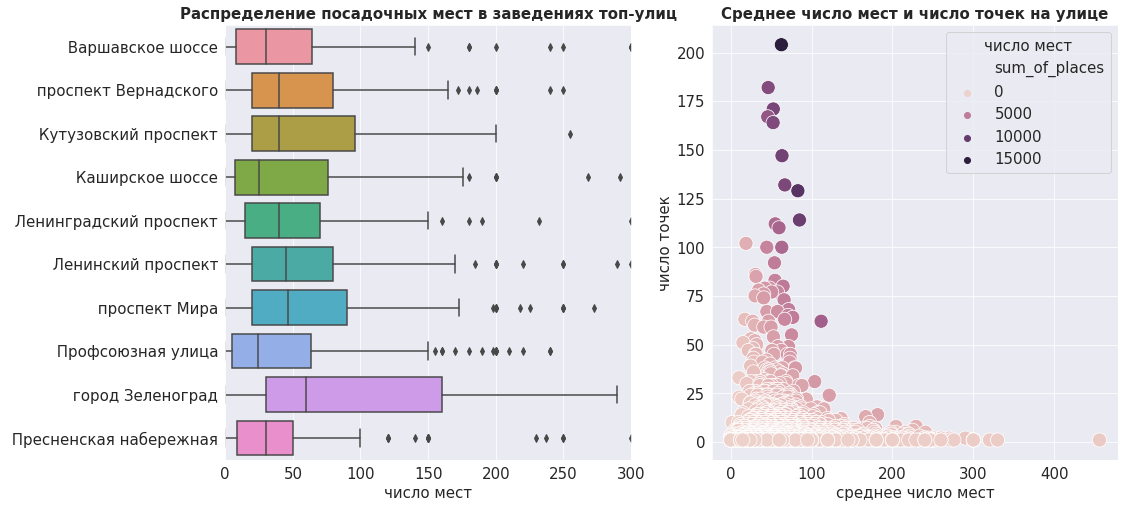

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
sns.boxplot(y='streetname', x='number', data=top_street_all)
plt.xlim(0,np.percentile(top_street_all['number'], 99))
plt.title('Распределение посадочных мест в заведениях топ-улиц', fontsize=15, fontweight="bold")
plt.ylabel('')
plt.xlabel('число мест', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.subplot(1,2,2)
sns.scatterplot(data=top_street_corr, x='mean_places', y='num_of_points', hue='sum_of_places', s=200)
plt.title('Среднее число мест и число точек на улице', fontsize=15, fontweight="bold")
plt.xlabel('среднее число мест',fontsize=15)
plt.ylabel('число точек',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title='число мест', title_fontsize=15, fontsize=15)
plt.show()

Заметно, что на улицах с большим (>50) количеством точек среднее число мест невелико (как правило до 100). Нельзя построить на одной центральной улице много больших ресторанов, а много маленьких - можно. Зеленоград - не улица, и в нем закономерность не работает.

## <a id="concl">Общие выводы</a> 

Исходя из условий задачи, мы решили открыть небольшое кафе с оригинальной концепцией. Небольшое кафе - это не сеть и не огромный ресторан; нам нужно найти условия, в которых наше заведение будет чувствовать себя лучше всего. 
1. Какой вид заведения стоит предпочесть? Кафе - оптимальный выбор, они - доминирующий вид, и, благодаря небольшим размерам организовать производство будет легче.
2. Какое количество посадочных мест оптимально? Среднее число посадочных мест в кафе - около 40, и разброс небольшой. Нам не следует брать больше.
3. В каком районе следует открываться? Не будучи знатоком административно-территориального деления Москвы, предположу, что лучше всего наш инновационный бизнес будет чувстовать себя в Центре. Там довольно много небольших кафе, которые успешно конкурируют друг с другом, а непрекращающийся поток туристов позволит быстро обрести популярность. Еще о конкуренции: во всех районах ЦАО есть улицы, на которых находится всего одно заведение: именно туда (на эти улицы) и стоит смотреть в первую очередь.
4. Сможем ли мы конкурировать с сетями? Да, большая часть кафе - несетевые. Если  бизнес взлетит - можно начинать строить сеть, при этом не перекраивая заведения в сторону увеличения посадочных мест: крупные сетевики выигрывают за счет множества небольших ресторанов.

## <a id="present">Презентация данных инвесторам</a> 

Презентация: <https://drive.google.com/file/d/1_RM-9Sw6-CuxZTV8bUb3Hajg6yf-ai9x/view?usp=sharing>